Label Image 에서 생성한 json 파일로 새로운 yolo dataset 들을 만든다


In [1]:
import os
import numpy as np
import pandas as pd
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
mask_model_ver = 132508

DATA_DIR = "/root/autodl-tmp/cervical_spine/"
IMAGES_DIR = os.path.join(DATA_DIR, 'yolo/images/')
LABELS_DIR = os.path.join(DATA_DIR, 'yolo/labels/')

BBOX_PATH = os.path.join(DATA_DIR, 'lm_labels/project-6-at-2022-10-23-10-49-ac1dfd72.json')

In [3]:
with open(BBOX_PATH) as json_file:
    bbox_data = json.load(json_file)

In [4]:
len(bbox_data)

7199

In [5]:
train_df = pd.DataFrame()
for data in tqdm(bbox_data):
    image = data['data']['image']
    UID = image.split('/')[-2]
    Slice = image.split('/')[-1].replace('.jpeg','')
    
    bbox = data['annotations'][0]['result'][0]['value']
    
    # coord = [bbox['x'], bbox['y'], bbox['width'], bbox['height']]
    
    new_s = pd.Series(data={
        'UID' : UID,
        'axial_index' : Slice,
        'x' : bbox['x'] * 5.12,
        'y' : bbox['y'] * 5.12,
        'width' : bbox['width'] * 5.12,
        'height' : bbox['height'] * 5.12
    })
    
    train_df = pd.concat((train_df, new_s.to_frame().T), axis=0)

train_df = train_df.sort_values(['UID','axial_index']).reset_index(drop=True)
print(len(train_df.UID.unique()))
print(len(train_df))
train_df.head()

100%|██████████| 7199/7199 [00:05<00:00, 1411.58it/s]

234
7199


,UID,axial_index,x,y,width,height
0,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
2,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
3,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
4,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [6]:
train_df['UID_Slice'] = train_df['UID'] + '.' + train_df['axial_index'].astype('string')
train_df = train_df.set_index('UID_Slice').astype({'axial_index': int})
print(len(train_df))
train_df.head()

7199


,UID,axial_index,x,y,width,height
UID_Slice,,,,,,
1.2.826.0.1.3680043.10051.132,1.2.826.0.1.3680043.10051,132,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,1.2.826.0.1.3680043.10051,133,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,1.2.826.0.1.3680043.10051,134,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,1.2.826.0.1.3680043.10051,135,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,1.2.826.0.1.3680043.10051,136,214.0,215.48637,27.0,43.51363


In [7]:
total_boundary_df = pd.read_csv(os.path.join(DATA_DIR, f'infered_boundary_{mask_model_ver}_2.csv'))
total_boundary_df['UID_Slice'] = total_boundary_df['StudyInstanceUID'] + '.' + total_boundary_df['Slice'].astype('string')
total_boundary_df = total_boundary_df.set_index('UID_Slice').astype({'Slice': int})
print(len(total_boundary_df))
total_boundary_df.head()

708779


,StudyInstanceUID,Slice,Start,pixel_spacing,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,,
1.2.826.0.1.3680043.10001.0,1.2.826.0.1.3680043.10001,0,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.1,1.2.826.0.1.3680043.10001,1,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.2,1.2.826.0.1.3680043.10001,2,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.3,1.2.826.0.1.3680043.10001,3,0,0.253906,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10001.4,1.2.826.0.1.3680043.10001,4,0,0.253906,0.0,0.0,512.0,512.0


In [8]:
total_boundary_df = total_boundary_df[total_boundary_df.StudyInstanceUID.isin(train_df.UID.unique())]
total_boundary_df = total_boundary_df[['Start','Slice', 'StudyInstanceUID','xmin','ymin','xmax','ymax']]
print(len(total_boundary_df))
total_boundary_df.head()

77339


,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax
UID_Slice,,,,,,,
1.2.826.0.1.3680043.10051.0,0,0,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.1,0,1,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.2,0,2,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.3,0,3,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0
1.2.826.0.1.3680043.10051.4,0,4,1.2.826.0.1.3680043.10051,0.0,0.0,512.0,512.0


In [9]:
total_df = pd.concat((total_boundary_df, train_df), axis=1)
print(len(total_df))
total_df.iloc[130:140]

77339


,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,y,width,height
UID_Slice,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,216.71419,17.3044,20.38517
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,216.71419,17.87844,25.24362
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,221.62546,27.00959,26.37454
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,215.48637,27.92726,37.51363
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,215.48637,27.0,43.51363
1.2.826.0.1.3680043.10051.137,0,137,1.2.826.0.1.3680043.10051,12.076729,0.0,405.923271,393.846542,1.2.826.0.1.3680043.10051,137.0,213.56364,216.71419,25.13455,47.92717
1.2.826.0.1.3680043.10051.138,0,138,1.2.826.0.1.3680043.10051,31.076729,0.0,424.923271,393.846542,1.2.826.0.1.3680043.10051,138.0,209.0,214.57591,36.06131,51.56834


In [10]:
total_df[['cx','cy']] = total_df[['x', 'y']].values - total_df[['xmin','ymin']].values
total_df[['img_width', 'img_height']] = total_df[['xmax','ymax']].values - total_df[['xmin','ymin']].values


total_df["xcenter"] = (total_df["cx"].values + (total_df["width"].values / 2)) / total_df["img_width"].values
total_df["ycenter"] = (total_df["cy"].values + (total_df["height"].values / 2)) / total_df["img_height"].values
total_df["width_norm"] = total_df["width"].values / total_df["img_width"].values
total_df["height_norm"] = total_df["height"].values / total_df["img_height"].values

total_df.iloc[130:140]

,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,width,height,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,...,17.3044,20.38517,176.200421,216.71419,393.846542,393.846542,0.469352,0.57613,0.043937,0.051759
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,...,17.87844,25.24362,185.487871,216.71419,393.846542,393.846542,0.493662,0.582298,0.045394,0.064095
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,...,27.00959,26.37454,171.744781,221.62546,393.846542,393.846542,0.47036,0.596204,0.068579,0.066967
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,...,27.92726,37.51363,173.417821,215.48637,393.846542,393.846542,0.475773,0.594758,0.070909,0.095249
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,...,27.0,43.51363,185.923271,215.48637,393.846542,393.846542,0.506348,0.602375,0.068555,0.110484
1.2.826.0.1.3680043.10051.137,0,137,1.2.826.0.1.3680043.10051,12.076729,0.0,405.923271,393.846542,1.2.826.0.1.3680043.10051,137.0,213.56364,...,25.13455,47.92717,201.486911,216.71419,393.846542,393.846542,0.543496,0.611095,0.063818,0.12169
1.2.826.0.1.3680043.10051.138,0,138,1.2.826.0.1.3680043.10051,31.076729,0.0,424.923271,393.846542,1.2.826.0.1.3680043.10051,138.0,209.0,...,36.06131,51.56834,177.923271,214.57591,393.846542,393.846542,0.497539,0.610289,0.091562,0.130935


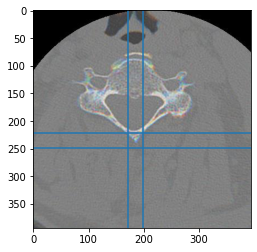

In [11]:
UID_Slice = '1.2.826.0.1.3680043.10051.134'
s = total_df.loc[UID_Slice]
img = Image.open(os.path.join(IMAGES_DIR, s.StudyInstanceUID, f'{s.Slice}.jpeg'))
plt.imshow(img)
plt.axvline(s.cx)
plt.axhline(s.cy)
plt.axvline(s.cx + s.width)
plt.axhline(s.cy + s.height)

In [12]:
total_df['img_path'] = IMAGES_DIR + total_df['StudyInstanceUID'] + '/' + total_df['Slice'].astype('string') + '.jpeg'
total_df.iloc[130:140]

,Start,Slice,StudyInstanceUID,xmin,ymin,xmax,ymax,UID,axial_index,x,...,height,cx,cy,img_width,img_height,xcenter,ycenter,width_norm,height_norm,img_path
UID_Slice,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051.130,0,130,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.131,0,131,1.2.826.0.1.3680043.10051,47.076729,0.0,440.923271,393.846542,NaN,NaN,NaN,...,NaN,NaN,NaN,393.846542,393.846542,NaN,NaN,NaN,NaN,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.132,0,132,1.2.826.0.1.3680043.10051,43.076729,0.0,436.923271,393.846542,1.2.826.0.1.3680043.10051,132.0,219.27715,...,20.38517,176.200421,216.71419,393.846542,393.846542,0.469352,0.57613,0.043937,0.051759,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.133,0,133,1.2.826.0.1.3680043.10051,36.076729,0.0,429.923271,393.846542,1.2.826.0.1.3680043.10051,133.0,221.5646,...,25.24362,185.487871,216.71419,393.846542,393.846542,0.493662,0.582298,0.045394,0.064095,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.134,0,134,1.2.826.0.1.3680043.10051,45.076729,0.0,438.923271,393.846542,1.2.826.0.1.3680043.10051,134.0,216.82151,...,26.37454,171.744781,221.62546,393.846542,393.846542,0.47036,0.596204,0.068579,0.066967,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.135,0,135,1.2.826.0.1.3680043.10051,41.076729,0.0,434.923271,393.846542,1.2.826.0.1.3680043.10051,135.0,214.49455,...,37.51363,173.417821,215.48637,393.846542,393.846542,0.475773,0.594758,0.070909,0.095249,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.136,0,136,1.2.826.0.1.3680043.10051,28.076729,0.0,421.923271,393.846542,1.2.826.0.1.3680043.10051,136.0,214.0,...,43.51363,185.923271,215.48637,393.846542,393.846542,0.506348,0.602375,0.068555,0.110484,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.137,0,137,1.2.826.0.1.3680043.10051,12.076729,0.0,405.923271,393.846542,1.2.826.0.1.3680043.10051,137.0,213.56364,...,47.92717,201.486911,216.71419,393.846542,393.846542,0.543496,0.611095,0.063818,0.12169,/root/autodl-tmp/cervical_spine/yolo/images/1....
1.2.826.0.1.3680043.10051.138,0,138,1.2.826.0.1.3680043.10051,31.076729,0.0,424.923271,393.846542,1.2.826.0.1.3680043.10051,138.0,209.0,...,51.56834,177.923271,214.57591,393.846542,393.846542,0.497539,0.610289,0.091562,0.130935,/root/autodl-tmp/cervical_spine/yolo/images/1....


## Write images.txt

In [13]:
# total_df[~total_df.UID.isna()].sample(10)

In [14]:
# total_df[~total_df.UID.isna()]['img_path'].to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# total_df['img_path'].to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')
# total_df.sample(16)['img_path'].to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

In [15]:
pos_df = total_df[~total_df.UID.isna()]
neg_df = total_df[total_df.UID.isna()]

print(len(pos_df))
print(len(neg_df))

7199
70140


In [16]:
# train_pos_df = pos_df.iloc[:100]
# train_neg_df = neg_df.iloc[:500]
train_pos_df = pos_df
train_neg_df = neg_df

train_pos_df['img_path'].to_csv('../third/yolov7_custom/data/train_pos.txt', header=None, index=None, sep=' ', mode='w')
train_neg_df['img_path'].to_csv('../third/yolov7_custom/data/train_neg.txt', header=None, index=None, sep=' ', mode='w')

val_df = train_pos_df.sample(16)
val_df['img_path'].to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

# t_df = total_df['img_path'].iloc[:int(len(total_df) * 0.8)]
# t_df.to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# t_df.to_csv('../third/yolov7_custom/data/train_custom.txt', header=None, index=None, sep=' ', mode='w')

# v_df = total_df['img_path'].iloc[int(len(total_df) * 0.8):]
# v_df.to_csv('../third/yolov7_custom/data/val_custom.txt', header=None, index=None, sep=' ', mode='w')

# e_df = v_df.sample(16)
# e_df.to_csv('../third/yolov7_custom/data/test_custom.txt', header=None, index=None, sep=' ', mode='w')


In [17]:
## Write labels
# don't need to save again
def save_label(s):
    file_dir = os.path.join(LABELS_DIR, s.StudyInstanceUID)
    if os.path.exists(file_dir) is False:
        os.mkdir(file_dir)
        
    file_path = os.path.join(file_dir, f'{s.Slice}.txt')
    
    with open(file_path, 'w') as f:
        f.write(f'0 {max(0, s.xcenter)} {max(0, s.ycenter)} {min(s.width_norm, 1.)} {min(s.height_norm, 1.)}')

# for i in tqdm(range(len(total_df))):
#     s = total_df.iloc[i]
    
#     if pd.isna(s.UID) == False:
#         save_label(s)